In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def GetDataframe():
    df = pd.read_csv('ml-latest-small/ratings.csv')
    df.drop('timestamp', axis=1, inplace=True)
    num_users = df.userId.unique().shape[0]
    num_items = df.movieId.unique().shape[0]

    print('Number of users: %d, number of items: %d.' % (num_users, num_items))
    return df, num_users, num_items

Number of users: 610, number of items: 9724.
Matrix sparsity: 0.017000


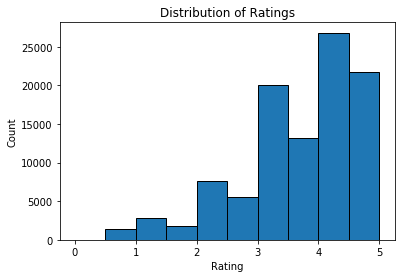

In [41]:
df, num_users, num_items = GetDataframe()

sparsity = len(df) / (num_users * num_items)
print('Matrix sparsity: %f' % sparsity)

plt.hist(df['rating'], bins=np.arange(0,5.5,0.5), ec='black')
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.show()

In [42]:
def GetRMatrix(data):
    X = data.values
    users = X[:,0]
    movies = X[:,1]

    movie_map = {}
    reverse_movie_map = {}
    new_id = 0
    for idx in range(len(movies)):
        item = int(movies[idx])
        if item not in movie_map:
            movie_map[item] = new_id
            reverse_movie_map[new_id] = item
            new_id += 1

    ratings = X[:,2]
    num_ratings = int(len(ratings))
    R = np.zeros((num_users, num_items))

    for i in np.arange(num_ratings):
        R[int(users[i]-1), movie_map[movies[i]]] = ratings[i]
        
    return R, movie_map, reverse_movie_map

R, movie_map, reverse_movie_map = GetRMatrix(df)

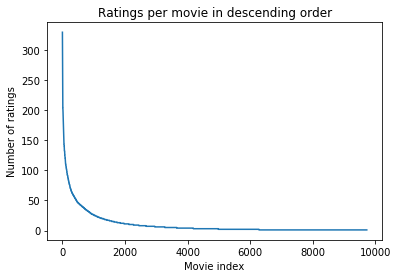

In [43]:
def PlotMovieRatings(R):
    is_rated = R!=0
    rat_per_movie = np.sum(is_rated,axis=0)
    sort_rat_per_movie=np.sort(rat_per_movie)

    plt.plot(sort_rat_per_movie[::-1])
    plt.title('Ratings per movie in descending order')
    plt.ylabel("Number of ratings")
    plt.xlabel("Movie index")
    plt.show()
    
PlotMovieRatings(R)

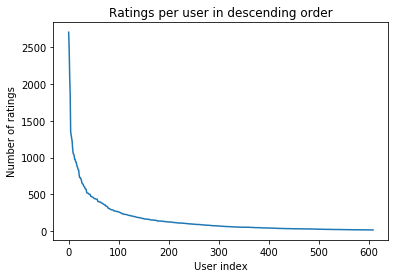

In [44]:
def PlotUserRatings(R):
    is_rated = R!=0
    rat_per_user = np.sum(is_rated,axis=1)
    sort_rat_per_user=np.sort(rat_per_user)

    plt.plot(sort_rat_per_user[::-1])
    plt.title('Ratings per user in descending order')
    plt.ylabel("Number of ratings")
    plt.xlabel("User index")
    plt.show()
    
PlotUserRatings(R)

3.501556983616962


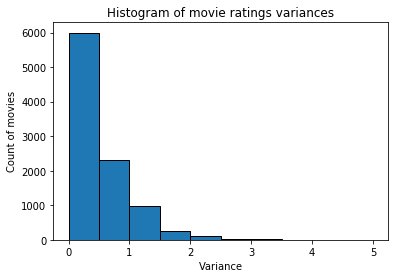

In [45]:
def PlotVarianceHist(R):
    nanR = R
    nanR[nanR == 0] = np.nan
    movie_vars = np.nanvar(nanR, axis = 0)
    movie_mean = np.nanmean(nanR)
    print(movie_mean)
    
    plt.hist(movie_vars, bins=np.arange(0,5.5,0.5), ec='black')
    plt.title('Histogram of movie ratings variances')
    plt.ylabel('Count of movies')
    plt.xlabel('Variance')
    plt.show()
    
PlotVarianceHist(R)

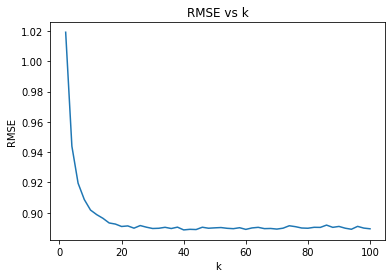

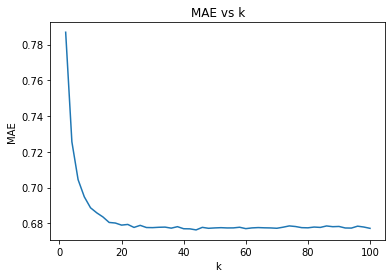

In [47]:
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import cross_validate
from surprise import Dataset
from surprise import Reader

reader = Reader(rating_scale=(0.5, 5))

data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

sim_options = {'name': 'pearson'}

ks = np.arange(2, 102, 2)
rmses = []
maes = []
for k in ks:
    algo = KNNWithMeans(k=k, sim_options=sim_options, verbose=False)
    res = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    rmses.append(np.mean(res['test_rmse']))
    maes.append(np.mean(res['test_mae']))
    
plt.plot(ks, rmses)
plt.title("RMSE vs k")
plt.ylabel("RMSE")
plt.xlabel("k")
plt.show()

plt.plot(ks, maes)
plt.title("MAE vs k")
plt.ylabel("MAE")
plt.xlabel("k")
plt.show()

In [ ]:
# from surprise import accuracy
# from surprise.model_selection import KFold

# kf = KFold(n_splits=10)
# algo = KNNWithMeans(k=k, sim_options=sim_options, verbose=False)

# rmse = 0.0
# for trainset, testset in kf.split(data):
#     algo.fit(trainset)
    
#     # trim testset
#     predictions = algo.test(testset)

#     rmse += accuracy.rmse(predictions)
    
# rmse /= 10
# print(rmse)